# Benchmarking of various implementations of FADDEEVA's error functions

In [1]:
from __future__ import division, print_function

Please compile the shared libraries by running the `Makefile`:

In [2]:
!make

## I. Setup

Import the multiprecision library `mpmath` as a reference for accuracy benchmarks:

In [3]:
import mpmath

Import the rest of the usual lot:

In [4]:
import numpy as np
import scipy
import sys
import time
from collections import OrderedDict
%load_ext Cython

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
%matplotlib inline

sns.set_style("white")
cmap = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 256))
cmap2 = matplotlib.colors.ListedColormap(sns.cubehelix_palette(8, 256))
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

Timer class for a more convenient timing:

In [6]:
class Timer(object):
    timing_fct = time.clock
    def __init__(self):
        self.timing_fct = Timer.timing_fct # saves one lookup to class
    def __enter__(self):
        self.start = Timer.timing_fct()
        return self

    def __exit__(self, *args):
        self.end = Timer.timing_fct()
        self.interval_s = self.end - self.start

The dictionary `wofz_impl` accesses the various function implementations.

Input interface is `wofz_impl[<implementation language>](x, y)`: 
`x` is the real and `y` is the imaginary part of the input, both should be numpy arrays (i.e. provide the ctypes field).

In [7]:
wofz_impl = OrderedDict()

### mpmath (reference)

set the precision:

In [8]:
mpmath.mp.dps = 50

prepare the `wofz_impl` entry:

In [9]:
def wofz(x, y):
    z = mpmath.mpc(x, y)
    w = mpmath.exp(-z**2) * mpmath.erfc(z * -1j)
    return w.real, w.imag
wofz_impl['mp'] = np.vectorize(wofz)

### scipy (version > 0.14)

http://ab-initio.mit.edu/wiki/index.php/Faddeeva_Package

In [10]:
from scipy.special import wofz as scipy_wofz

prepare the `wofz_impl` entry:

In [11]:
def wofz(x, y):
    z = scipy_wofz(x + 1j*y)
    return z.real, z.imag
wofz_impl['scipy'] = wofz

### cernlib_c


embedding the file in cython:

(N.B.: our implementation here relies on 2D numpy.ndarray inputs)

In [12]:
%%cython --name cernlib_c
# distutils: sources = ./cernlib_c/ErrorFunctions.c

import numpy as np
cimport numpy as np

cdef extern void cerrf(double in_real, double in_imag, double* out_real, double* out_imag)

cpdef tuple wofz(np.ndarray[double, ndim=2, mode="c"] in_real,
                 np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            cerrf(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

prepare the `wofz_impl` entry:

In [13]:
import cernlib_c
wofz_impl['c'] = cernlib_c.wofz

### cernlib_cuda

try whether PyCUDA is available for the CUDA FADDEEVA version:

In [14]:
i_pycuda = False
try:
    from pycuda.autoinit import context
    from pycuda import gpuarray
    from pycuda.elementwise import ElementwiseKernel
    i_pycuda = True
except ImportError as e:
    context = None
    print ('No PyCUDA available, as per error message:')
    print (e.message)

define special GPU Timer:

In [15]:
class GPUTimer(object):
    '''Use time.time() for GPU as timer.clock() doesn't work...'''
    timing_fct = time.time
    def __init__(self):
        self.timing_fct = Timer.timing_fct # saves one lookup to class

    def __enter__(self):
        self.start = Timer.timing_fct()
        return self

    def __exit__(self, *args):
        context.synchronize()
        self.end = Timer.timing_fct()
        self.interval_s = self.end - self.start

prepare the CUDA kernel for the wofz function:

In [16]:
if i_pycuda:
    kernel = ElementwiseKernel(
        'double* in_real, double* in_imag, double* out_real, double* out_imag',
#         'out_real[i] = in_real[i]; out_imag[i] = in_imag[i]',
        'wofz(in_real[i], in_imag[i], &out_real[i], &out_imag[i]);',
        'wofz_kernel',
        preamble=open('cernlib_cuda/wofz.cu', 'r').read()
    )

prepare the `wofz_impl` entry:

(N.B.: the function call will include the transfers to and from the GPU!)

In [17]:
if i_pycuda:
    def wofz(x, y):
        in_real = gpuarray.to_gpu(np.atleast_1d(x).astype(np.float64))
        in_imag = gpuarray.to_gpu(np.atleast_1d(y).astype(np.float64))
        out_real = gpuarray.empty(in_real.shape, dtype=np.float64)
        out_imag = gpuarray.empty(in_imag.shape, dtype=np.float64)
        kernel(in_real, in_imag, out_real, out_imag)
        return out_real.get(), out_imag.get()
    wofz_impl['cuda'] = wofz

### cernlib_f90_1

import and numpy-vectorise the first f90 version:

(N.B.: You need to have called the `Makefile` beforehand in order to have the compiled shared fortran libraries available!)

In [18]:
sys.path.append('cernlib_f90_1')
from wwerf import ccperrfr

wofz_impl['f90-1'] = np.vectorize(ccperrfr)

### cernlib_f90_2

import and numpy-vectorise the second f90 version:

In [19]:
sys.path.append('cernlib_f90_2')
from wwerf2 import errf

wofz_impl['f90-2'] = np.vectorize(errf)

### cernlib_root_adapted

In [20]:
%%cython --name cernlib_root_adapted
# distutils: include_dirs = ./cernlib_root_adapted/erfc.h
# distutils: sources = ./cernlib_root_adapted/erfc.c
# distutils: extra_compile_args = -std=c99 -W -Wall -Wextra -pedantic -O3 -ftree-vectorize

import numpy as np
cimport numpy as np

cdef extern void wofz (double in_re, double in_im, double* out_re, double* out_im)
# cdef extern void wofzf(float in_re, float in_im, float* out_re, float* out_im)

cpdef tuple wofz_cython(np.ndarray[double, ndim=2, mode="c"] in_real,
                        np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            wofz(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [21]:
from cernlib_root_adapted import wofz_cython

wofz_impl['c-root-adapt'] = wofz_cython

### cernlib-root-adapted -DFAST_IMPL

In [22]:
%%cython --name cernlib_root_adapted_dfastimpl
# distutils: include_dirs = ./cernlib_root_adapted/erfc.h
# distutils: sources = ./cernlib_root_adapted/erfc.c
# distutils: extra_compile_args = -std=c99 -W -Wall -Wextra -pedantic -O3 -ftree-vectorize -DFAST_IMPL

import numpy as np
cimport numpy as np

cdef extern void wofz(double in_re, double in_im, double* out_re, double* out_im)

cpdef tuple wofz_cython(np.ndarray[double, ndim=2, mode="c"] in_real,
                        np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            wofz(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [23]:
from cernlib_root_adapted_dfastimpl import wofz_cython

wofz_impl['c-root-adapt-fast'] = wofz_cython

### cernlib-root-adapted -DSINCOS

In [24]:
%%cython --name cernlib_root_adapted_dsincos
# distutils: include_dirs = ./cernlib_root_adapted/erfc.h
# distutils: sources = ./cernlib_root_adapted/erfc.c
# distutils: extra_compile_args = -std=c99 -W -Wall -Wextra -pedantic -O3 -ftree-vectorize -DSINCOS

import numpy as np
cimport numpy as np

cdef extern void wofz(double in_re, double in_im, double* out_re, double* out_im)

cpdef tuple wofz_cython(np.ndarray[double, ndim=2, mode="c"] in_real,
                        np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            wofz(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [25]:
from cernlib_root_adapted_dsincos import wofz_cython

wofz_impl['c-root-adapt-sincos'] = wofz_cython

## II. Accuracy Benchmark

### Accuracy within range $10^{-8}$ to $10^8$

(outside of this, the `mpmath` multiplications of extremely large and small factors do not behave well)

define range:

In [26]:
exp_min = -8
exp_max = 8

r = 10**np.linspace(exp_min, exp_max, 101)
x, y = np.meshgrid(r, r)

the reference values via `mpmath`:

In [27]:
# takes ~10sec
wr_ref, wi_ref = wofz_impl['mp'](x, y)

/home/oeftiger/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


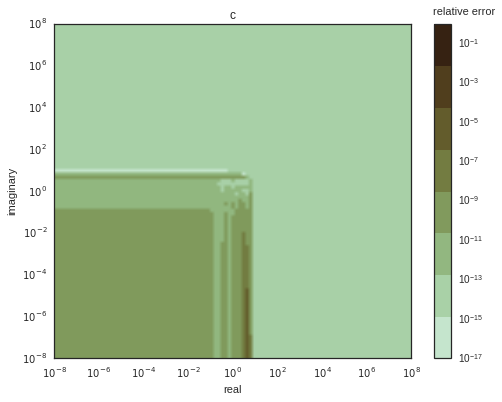

In [28]:
def plot_error(x,y,z, title, unify=True):
    fig, ax = plt.subplots(figsize=(8,6))
    if unify:
        z = np.clip(a=z, a_min=1e-17, a_max=1e0)
        im  = ax.imshow(
                   #np.vectorize(mpmath.log10)(z).astype(np.float64),
                   z.astype(np.float64),
                   origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto',
                   vmin=1e-17, vmax=1e0, norm=LogNorm(),
                   cmap=cmap2)
    else:
        im = ax.imshow(np.vectorize(mpmath.log10)(z).astype(np.float64),
                       origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto',
                       cmap=cmap2)

    # Plot look: axes, title, ticks, ...
    cbar = plt.colorbar(im)
    cbar.set_label('relative error', labelpad=-18, y=1.05, rotation=0)
    ax.set_title(title)
    ax.set_xlabel('real')
    ax.set_ylabel('imaginary')
    ax.set_xticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    ax.set_yticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    
    return fig, ax

test = True
if test is True:
    wr, wi = wofz_impl['c'](x, y)
    z = abs(wr - wr_ref)/wr_ref
    #z = abs(wi - wi_ref)/wi_ref
    fig, ax = plot_error(x,y,z, title='c',unify=True)

### Compare the relative errors for the different implementations
You can either plot the real or the imaginar parts by setting z to real_error or imag_error

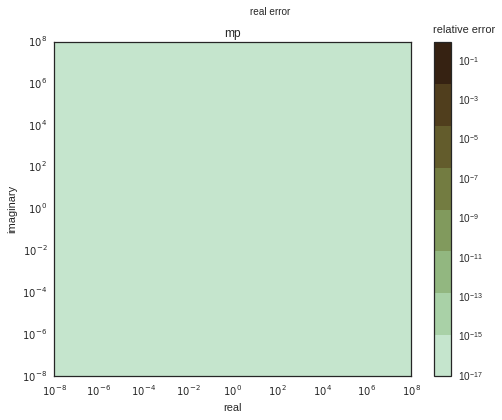

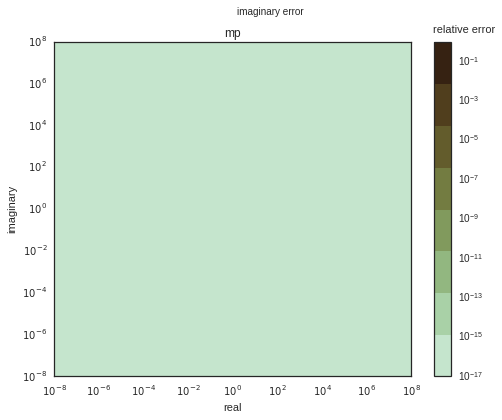

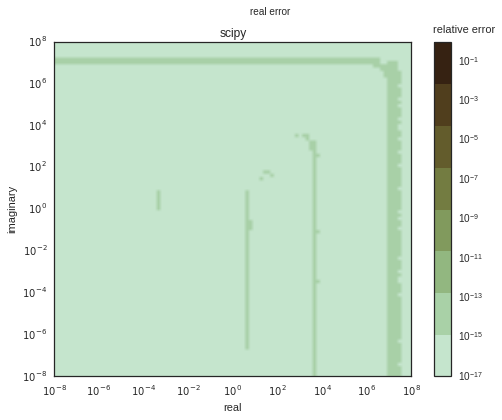

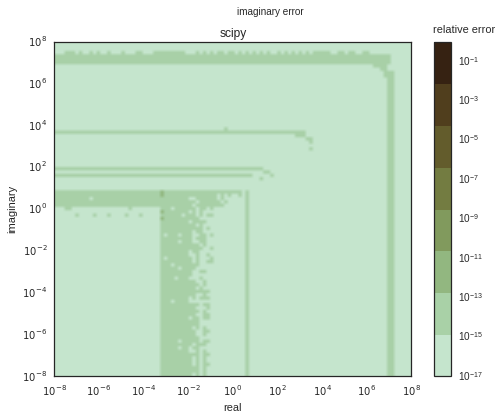

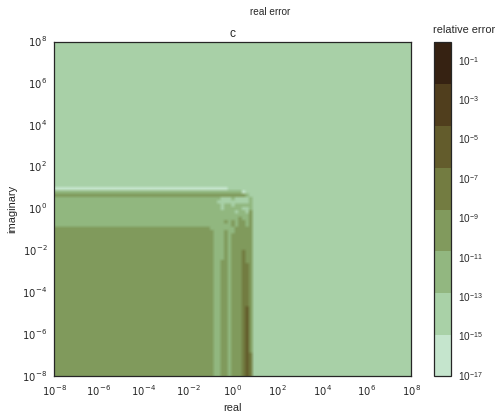

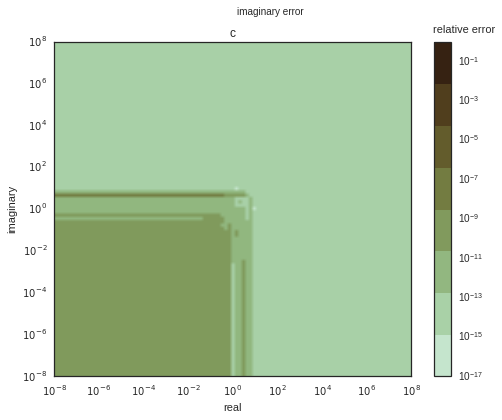

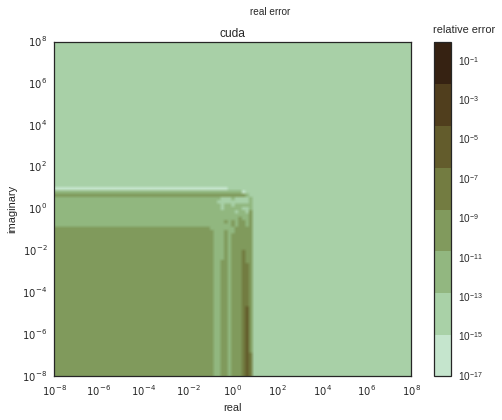

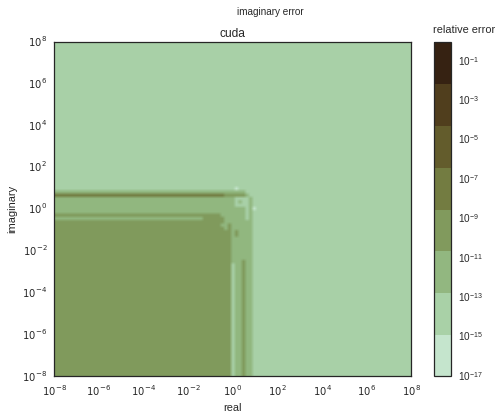

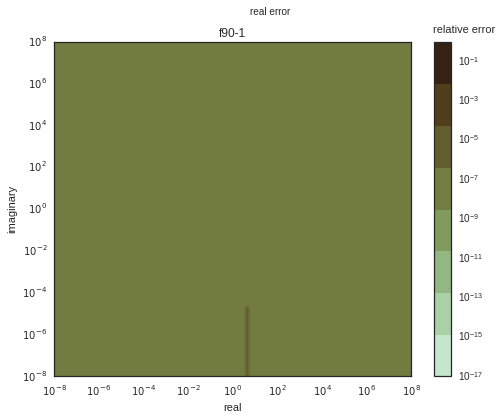

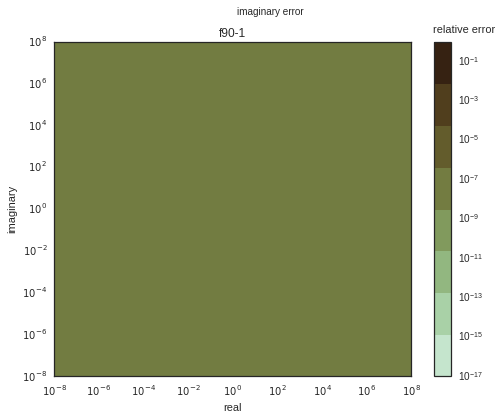

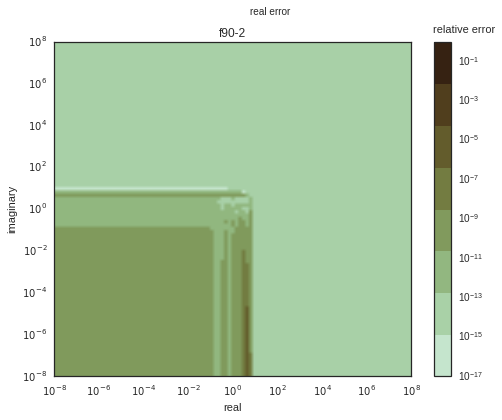

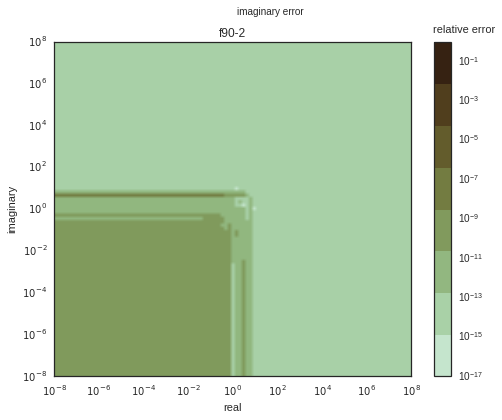

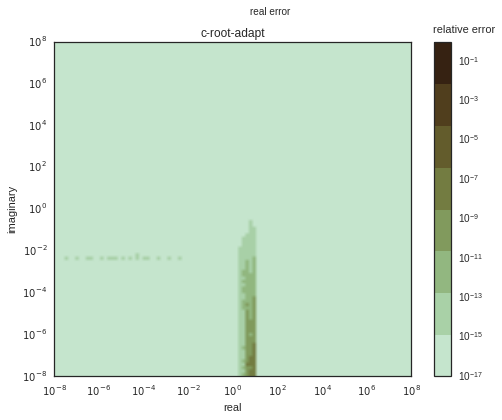

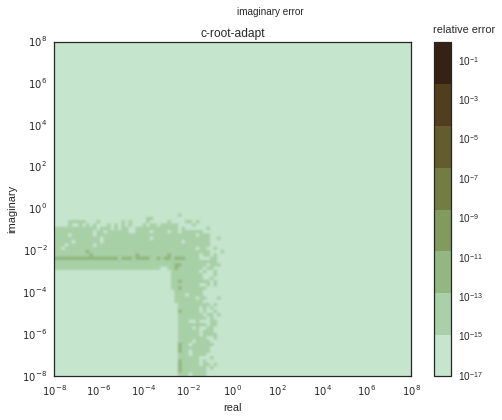

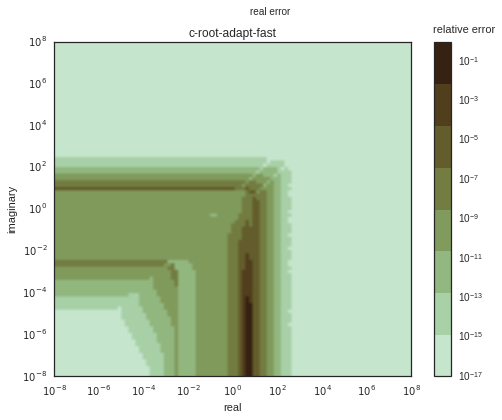

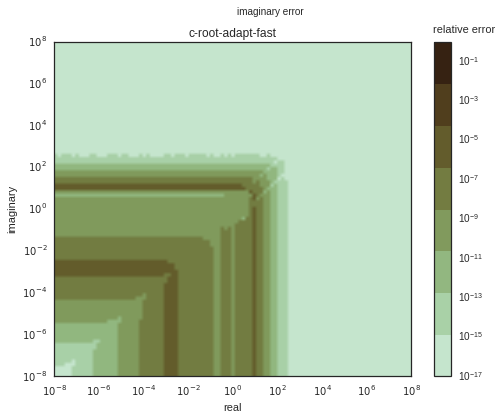

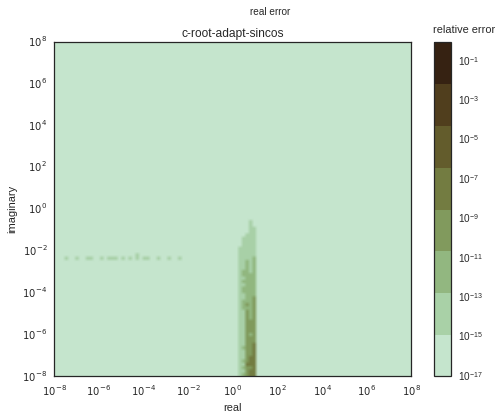

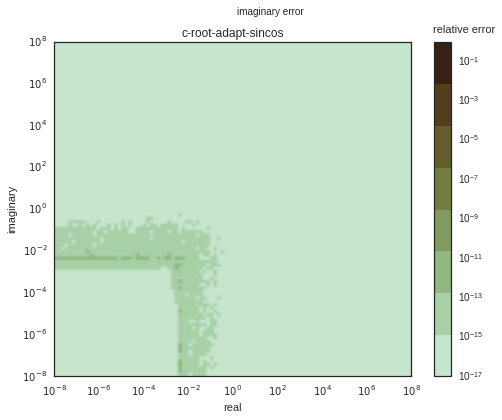

In [29]:
for implementation, function in wofz_impl.iteritems():
    wr, wi = function(x, y)
    real_error = np.abs(wr - wr_ref)/wr_ref
    imag_error = np.abs(wi - wi_ref)/wi_ref
    plot_error(x, y, real_error, title=implementation, unify=True)
    plt.suptitle('real error')
    plot_error(x, y, imag_error, title=implementation, unify=True)
    plt.suptitle('imaginary error')


## III. Timing Benchmark

In [30]:
def plot_timing(x,y,z, title):
    fig, ax = plt.subplots(figsize=(8,6))
    z = np.clip(a=z, a_min=1e-17, a_max=1e0)
    z *= 1e6 # make us out of s
    im  = ax.imshow(
                   z.astype(np.float64),
                   origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto',
    )


    # Plot look: axes, title, ticks, ...
    cbar = plt.colorbar(im)
    cbar.set_label('t [us] per call', labelpad=-18, y=1.05, rotation=0)
    ax.set_title(title)
    ax.set_xlabel('real')
    ax.set_ylabel('imagiary')
    ax.set_xticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    ax.set_yticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    
    return fig, ax

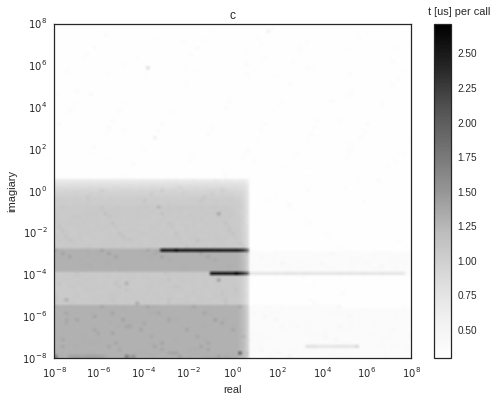

In [31]:
exp_min = -8
exp_max = 8

r = 10**np.linspace(exp_min, exp_max, 101)
x, y = np.meshgrid(r, r)

def dummy(a,b):
    pass

def timeit(x,y, function, ones_array, nrep_timing=3, n_entries_array=50, Timer=Timer):
    '''Time the implementation on the arrays x,y = x + iy'''
    T = np.zeros_like(x)
    timings = np.zeros(nrep_timing, dtype=np.float32)
    for el in xrange(len(x)):
        for el2 in xrange(len(x[0])):
            xx = ones_array * x[el][el2]
            yy = ones_array * y[el][el2]
            for i in xrange(nrep_timing):
                with Timer() as t:
                    wr, wi = function(xx, yy)
                timings[i] = t.interval_s
            T[el,el2] = np.median(timings)/n_entries_array
            dummy(wr,wi) # use wr, wi, otherwise they might get optimized away
    return T
if test is True:
    fn = wofz_impl['c']
    z = timeit(x,y, fn, np.ones((1,50), dtype=np.float64))
    plot_timing(x,y,z, 'c')

scipy
c
cuda
f90-1
f90-2
c-root-adapt
c-root-adapt-fast
c-root-adapt-sincos


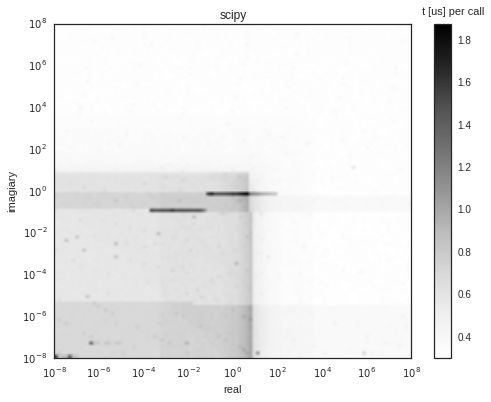

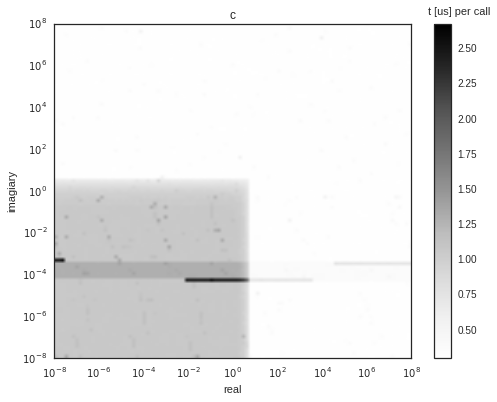

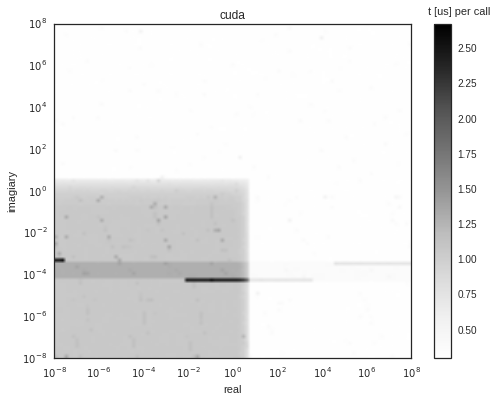

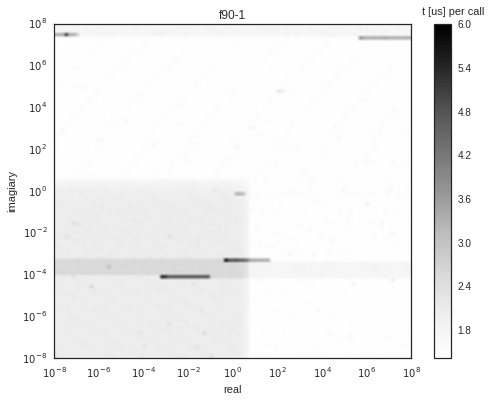

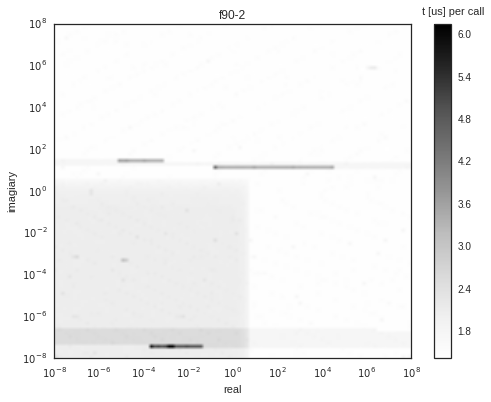

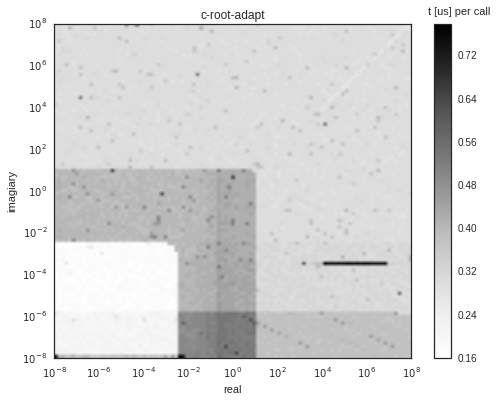

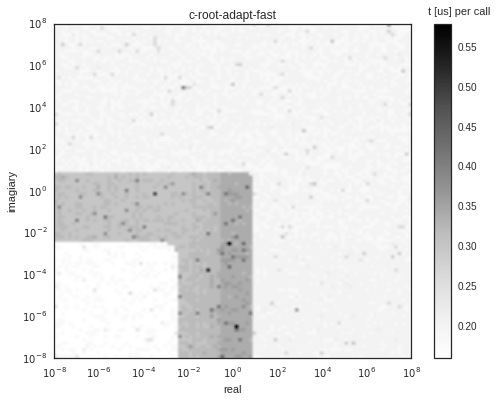

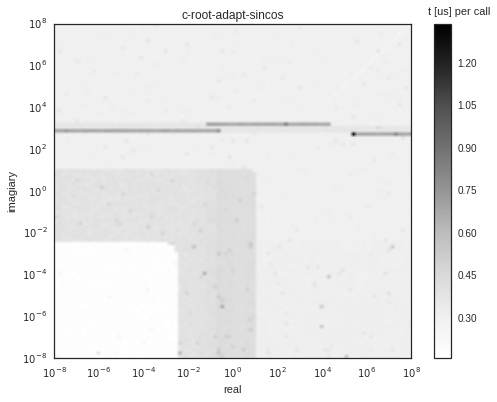

In [32]:
n_entries_array = 50

timings_avg = OrderedDict()

for implementation, function in wofz_impl.iteritems():
    if implementation is not 'mp':
        print (implementation)
        # CUDA should be timed without host-device memory transfers:
        if implementation is 'cuda':
#             z = timeit(gpuarray.to_gpu(x), gpuarray.to_gpu(y), kernel, 
#                        gpuarray.empty((1,int(1e8)), dtype=np.float64).fill(1.),
#                        n_entries_array=int(1e8), Timer=GPUTimer).get()
            pass
        else:
            z = timeit(x,y, function, np.ones((1,n_entries_array), dtype=np.float64))
            timings_avg[implementation] = np.mean(z)
        plot_timing(x,y,z, title=implementation)
#         plot_timing(x,y,z, title=implementation)

In [33]:
name_len = max(map(len, wofz_impl))
for impl in sorted(timings_avg, key=timings_avg.__getitem__):
    print (('{impl:' + str(name_len) + 
           's}: {avg_time:.3f} us/call').format(
                impl=impl, avg_time=timings_avg[impl]*1e6))

c-root-adapt-fast  : 0.215 us/call
c-root-adapt-sincos: 0.312 us/call
c-root-adapt       : 0.319 us/call
scipy              : 0.443 us/call
c                  : 0.539 us/call
f90-2              : 1.662 us/call
f90-1              : 1.672 us/call


# IV. Memory Footprint
Computed by hand, counting the number of variables and lookup tables. Neglecting the memory needed by calls to pow, exp etc. Assuming 4 bytes for integers. Not counting the memory for the input and output. Constants are treated as variables of the corresponding size. Variables: all declarations of variables, even if they might be eliminated by the compiler. Tables: all memory used to store fixed constants, lookup tables, ... . Some values are estimates because they depend on the program flow (if/else branches).
- cernlib-c: 684 Bytes
- f90-1: 692 Bytes
- f90-2: 716 Bytes
- cernlib-cuda: 684 Bytes
- cernlib-root-adapted-FAST_IMPL: Tables: 704 Bytes, Vars: ~350 Bytes
- cenlib-root-adapted: Tables: 2688 Bytes, Vars: ~ 600 Bytes




#  V. Comments

## include C via cython instead of ctypes

Cython allows to call the C function in a less involved way which leads to much less overhead and therefore more realistic C performance. This fact is also partly due to the numpy.ndarray output creation being implemented on the C side and not in python (as it happens in the ctypes case).

Ctypes rely on calling the `Makefile` before running this section.

Defining the cython interface:

In [34]:
%%cython --name cernlib_c_cython
# distutils: sources = ./cernlib_c/ErrorFunctions.c

import numpy as np
cimport numpy as np

cdef extern void cerrf(double in_real, double in_imag, double* out_real, double* out_imag)

cpdef tuple wofz(np.ndarray[double, ndim=2, mode="c"] in_real,
                 np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            cerrf(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [35]:
from cernlib_c_cython import wofz as test_cython

Defining the ctypes interface:

In [36]:
import ctypes
from numpy.ctypeslib import ndpointer
np_double_p = ndpointer(dtype=np.float64)

dll = ctypes.cdll.LoadLibrary('cernlib_c/wofz.so')
dll.cerrf.restype = None
dll.cerrf.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def test_ctypes(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dll.cerrf(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]

test_ctypes = np.vectorize(test_ctypes)

For single values, there is already a huge difference (half of which comes from the numpy allocation and ctypes conversion):

In [37]:
a, b = np.atleast_2d(1.), np.atleast_2d(2.)

In [38]:
print ('ctypes implementation:')
t_ctypes = %timeit -o -c test_ctypes(a, b)
print ('\n\ncython implementation:')
t_cython = %timeit -o -c test_cython(a, b)
print ('\n\nratio between ctypes and cython:\n{0:.2f}'.format(
    t_ctypes.best / t_cython.best))

ctypes implementation:
The slowest run took 6.26 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 110 µs per loop


cython implementation:
The slowest run took 11.79 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.15 µs per loop


ratio between ctypes and cython:
26.47


For large arrays it becomes even more evident:

In [39]:
exp_min = -8
exp_max = 8

r = 10**np.linspace(exp_min, exp_max, 101)
x, y = np.meshgrid(r, r)

In [40]:
print ('ctypes implementation:')
t_ctypes = %timeit -o -c test_ctypes(x, y)
print ('\n\ncython implementation:')
t_cython = %timeit -o -c test_cython(x, y)
print ('\n\nratio between ctypes and cython:\n{0:.2f}'.format(
       t_ctypes.best / t_cython.best))

ctypes implementation:
1 loops, best of 3: 249 ms per loop


cython implementation:
100 loops, best of 3: 3.95 ms per loop


ratio between ctypes and cython:
63.04


## Impact of C compiler options to cython

By using more aggressive compiler options for `gcc` one can improve the cythonised functions in terms of speed:

In [41]:
%%cython --name cernlib_c_cython_aggr
# distutils: sources = ./cernlib_c/ErrorFunctions.c
# distutils: extra_compile_args = -std=c99 -W -Wall -Wextra -pedantic -O3 -ftree-vectorize

import numpy as np
cimport numpy as np

cdef extern void cerrf(double in_real, double in_imag, double* out_real, double* out_imag)

cpdef tuple wofz(np.ndarray[double, ndim=2, mode="c"] in_real,
                 np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            cerrf(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [42]:
from cernlib_c_cython_aggr import wofz as test_cython_aggr

The corresponding timing as in the previous section shows no influence from the more aggressive compiler options:

In [43]:
print ('default cython implementation:')
t_cython_def = %timeit -o -c test_cython(a, b)
print ('\n\ncompiler flag optimised cython implementation:')
t_cython_aggr = %timeit -o -c test_cython_aggr(a, b)
print ('\n\nratio between default and optimised:\n{0:.2f}'.format(
       t_cython_def.best / t_cython_aggr.best))

default cython implementation:
The slowest run took 14.33 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.19 µs per loop


compiler flag optimised cython implementation:
100000 loops, best of 3: 4.23 µs per loop


ratio between default and optimised:
0.99


The results are still the same:

In [44]:
res_def = np.array(test_cython(x, y))
res_aggr = np.array(test_cython_aggr(x, y))
print ('Identical arrays? -->', np.all(res_def == res_aggr))

Identical arrays? --> True


### -ffast-math introduces small errors but improves the speed

In [45]:
%%cython --name cernlib_c_cython_fastmath
# distutils: sources = ./cernlib_c/ErrorFunctions.c
# distutils: extra_compile_args = -ffast-math

import numpy as np
cimport numpy as np

cdef extern void cerrf(double in_real, double in_imag, double* out_real, double* out_imag)

cpdef tuple wofz(np.ndarray[double, ndim=2, mode="c"] in_real,
                 np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            cerrf(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [46]:
from cernlib_c_cython_fastmath import wofz as test_cython_fastmath

The corresponding timing as in the previous section shows a few percents difference for small array lengths:

In [47]:
print ('default cython implementation:')
t_cython_def = %timeit -o -c test_cython(a, b)
print ('\n\nfastmath optimised cython implementation:')
t_cython_fastmath = %timeit -o -c test_cython_fastmath(a, b)
print ('\n\nratio between default and optimised:\n{0:.2f}'.format(
       t_cython_def.best / t_cython_fastmath.best))

default cython implementation:
The slowest run took 12.68 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.42 µs per loop


fastmath optimised cython implementation:
The slowest run took 12.49 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.16 µs per loop


ratio between default and optimised:
1.06


... which is negligible for large arrays:

In [48]:
print ('default cython implementation:')
t_cython_def = %timeit -o -c test_cython(x, y)
print ('\n\nfastmath optimised cython implementation:')
t_cython_fastmath = %timeit -o -c test_cython_fastmath(x, y)
print ('\n\nratio between default and optimised:\n{0:.2f}'.format(
       t_cython_def.best / t_cython_fastmath.best))

default cython implementation:
100 loops, best of 3: 3.94 ms per loop


fastmath optimised cython implementation:
100 loops, best of 3: 3.93 ms per loop


ratio between default and optimised:
1.00


-fast-math introduces small errors though:

In [49]:
res_def = np.array(test_cython(x, y))
res_fastmath = np.array(test_cython_fastmath(x, y))
print ('Identical arrays? -->', np.all(res_def == res_fastmath))

Identical arrays? --> False


with the maximal absolute error being

In [50]:
np.max(res_def - res_fastmath)

1.3322676295501878e-15